## Win/Loss Betting Model


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from spcl_case import *
plt.style.use('fivethirtyeight')

Obtain results of teams within the past year

In [335]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv')
h_matches['Date'] = pd.to_datetime(h_matches['Date'])
h_teams = pd.read_csv('hltv_csv/teams.csv')
h_teams = fix_teams(h_teams.set_index('ID'))

In [336]:
MIN_DATE = dt.datetime(2017,1,1)
EVENT_SET = 'mdlau'
FILTER_TEAMS = {'eslpl': ['OpTic', 'SK', 'Cloud9', 'Liquid', 'Luminosity', 'Misfits', 'Renegades', 'Immortals', 
                    'Splyce', 'compLexity', 'Rogue', 'Ghost', 'CLG', 'NRG',
                    'BIG', 'LDLC', 'mousesports', 'EnVyUs', 'NiP', 'Virtus.pro', 
                    'Astralis', 'G2', 'GODSENT', 'Heroic', 'fnatic', 'NiP', 'G2', 'Heroic'],
                'mdleu': ['Virtus.pro', 'FlipSid3', 'eXtatus', 'AGO', 'Fragsters', 'Gambit', 'PRIDE', '1337HUANIA', 
                    'VITALIS', 'Epsilon', 'CHAOS', 'Crowns', 'MK', 'Japaleno', 'Not Academy', 'aAa', 'Space Soldiers',
                    'Singularity', 'Nexus', 'Invictus Aquilas', 'Spirit', 'Kinguin', 'Seed', 'Endpoint', 'iGame.com', 'TEAM5',
                    'ALTERNATE aTTaX'],
                'mdlna': ['Gale Force', 'FRENCH CANADIANS', 'Mythic', 'GX', 'Beacon', 'Torqued', 'Rise Nation', 'Denial', 'subtLe', 
                   'SoaR', 'Muffin Lightning', 'Iceberg', 'ex-Nitrious', 'Adaptation', 'Morior Invictus', 'Naventic', 'CheckSix', 'Good People'
                   , 'LFAO', 'CLG Academy', 'Ambition', 'Mostly Harmless', 'Gorilla Core', 'ex-Nitrious', 'ANTI ECO'],
                'mdlau': ['Grayhound', 'Tainted Minds', 'Kings', 'Chiefs', 'Dark Sided', 'seadoggs', 'Athletico', 'Legacy',
                    'SIN', 'Noxide', 'Control', 'SYF', 'Corvidae', 'Funkd', 'Masterminds', 'Conspiracy', 'AVANT']
               }

h_matches = h_matches[h_matches['Date'] >= MIN_DATE]
h_filter_teams = h_teams[h_teams['Name'].isin(FILTER_TEAMS[EVENT_SET])]
h_matches = h_matches[h_matches['Team 1 ID'].isin(h_filter_teams.index) | h_matches['Team 2 ID'].isin(h_filter_teams.index)]
h_matches['winner'] = h_matches.apply(lambda x: x['Team 1 ID'] if x['Team 1 Score'] > x['Team 2 Score'] else x['Team 2 ID'], axis=1)
h_matches['score_diff'] = h_matches['Team 1 Score'] - h_matches['Team 2 Score']

In [337]:
obs = h_matches[['Map', 'Team 1 ID', 'Team 2 ID', 'score_diff', 'winner']]
obs = obs[obs.Map != 'Default']
obs.head()

,Map,Team 1 ID,Team 2 ID,score_diff,winner
23848,Train,7517,7104,10,7517
23849,Cache,7517,6134,-7,6134
23868,Dust2,7517,7220,4,7517
23869,Cache,7517,7220,-10,7220
23870,Mirage,7517,7220,3,7517


In [338]:
teams = np.sort(np.unique(np.concatenate([h_matches['Team 1 ID'], h_matches['Team 2 ID']])))
maps = obs.Map.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
mmap = {v:k for k,v in dict(enumerate(maps)).items()}
n_teams = len(teams)
n_maps = len(maps)
print('Number of Teams: %i ' % n_teams)
print('Number of Matches: %i ' % len(h_matches))
print('Number of Maps: %i '% n_maps)

Number of Teams: 69 
Number of Matches: 995 
Number of Maps: 8 


## Pymc Model

Determining Binary Win Loss: $wl_{m,i,j}$
$$
\omega, \tau, \sim HC(0.5) \\
R_{k} \sim N(0, \omega^2) \\
\tilde{\theta}_{m,k} \sim N(0,1) \\
R_{m,k} = R_{k} + \tau\tilde{\theta} \\
wl_{m,i,j} \sim B(p = \text{Sig}(R_{m,i}-R_{m,j})) \\
$$

and score difference: $sc_{m,i,j}$

$$
\alpha \sim Gamma(10,5) \\
\kappa_{m,i,j} = 32\text{Sig}(\alpha(R_{m,i}-R_{m,j}))-16 \\
\sigma_{m} \sim HC(0.5) \\
sc_{m,i,j} \sim N(\kappa, \sigma_{m}^2)
$$

In [351]:
mr = trace['rating | map'].mean(axis=0).flatten()

In [366]:
mr[obs_map*n_teams+obs_team_1]

array([ 1.04365261,  1.70461855,  2.10743498,  1.70461855,  1.69754821,
        3.18727709,  3.07291358, -1.36041145,  0.11543782,  1.64415136,
        3.14371287,  1.48801433,  1.627531  ,  1.82588726,  0.45415659,
        2.02903244,  2.19841809,  1.9957424 ,  0.8603818 ,  1.89535284,
        1.82588726,  0.90750611,  1.10781879,  1.71343568,  3.22532359,
        2.36255971, -0.43880797,  0.02859383,  2.36255971,  3.08236458,
        0.02859383, -0.5471208 ,  0.77010687,  0.13628701,  1.1808837 ,
        1.98736548,  0.49772899, -2.56962406, -1.79557711, -0.59506124,
       -1.04070444, -2.56962406,  3.14371287,  3.08236458,  2.4857206 ,
        2.45581464, -0.23495837, -1.22537065, -2.55655709, -2.07702989,
       -2.07702989, -2.37603061,  1.59651859,  3.22532359,  0.99030272,
        0.45415659, -0.5471208 , -0.70041576,  0.25985367, -0.5471208 ,
        0.84156119,  0.45415659, -0.77777278, -0.5471208 ,  0.84156119,
       -1.80567459,  3.22532359,  3.14371287,  2.45581464,  1.59

In [339]:
import pymc3 as pm
import theano.tensor as tt

In [ ]:
obs_map = obs['Map'].map(mmap).values
obs_team_1 = obs['Team 1 ID'].map(tmap).values
obs_team_2 = obs['Team 2 ID'].map(tmap).values
bin_enc = np.zeros((len(obs), n_maps*n_teams))
bin_enc[np.arange(len(obs)), obs_map*n_teams+obs_team_1] = 1
bin_enc[np.arange(len(obs)), obs_map*n_teams+obs_team_2] = -1
bin_enc = tt.as_tensor_variable(bin_enc)

with pm.Model() as rating_model:
    
    omega = pm.HalfCauchy('omega', 0.5)
    tau = pm.HalfCauchy('tau', 0.5)
    rating = pm.Normal('rating', 0, omega, shape=n_teams)
    theta_tilde = pm.Normal('rate_t', mu=0, sd=1, shape=(n_maps, n_teams))
    rating_map = pm.Deterministic('rating | map', rating + tau * theta_tilde)
    
    diff = tt.dot(bin_enc, rating_map.flatten())
    #diff = rating_map[obs_map, obs_team_1] - rating_map[obs_map, obs_team_2]
    p = pm.math.sigmoid(diff)
    alpha = 0.3485
    kappa = 32*pm.math.sigmoid(alpha*diff)-16.
    sigma = pm.HalfCauchy('sigma', 0.5, shape=n_maps)
    
    sc = pm.Normal('observed score diff', kappa, sigma[obs_map], observed=obs['score_diff'])
    wl = pm.Bernoulli('observed wl', p=p, observed=(obs['Team 1 ID'] == obs['winner']).values)

In [ ]:
with rating_model:
    #start = approx.sample(1)[0]
    #trace = pm.sample(5000, init='advi', nuts_kwargs={'target_accept': 0.99}, tune=0)
    trace = pm.sample(5000, n_init=20000, init='advi+adapt_diag', nuts_kwargs={'target_accept': 0.90}, tune=1000) # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 3,948.3:  88%|████████████████████████████████████████████▊      | 17583/20000 [01:04<00:08, 273.88it/s]
Interrupted at 17,602 [88%]: Average Loss = 33,848
 11%|████████▉                                                                      | 675/6000 [04:00<31:40,  2.80it/s]

{'AVANT': 0.47336902231842193,
 'Athletico': 0.47764479049361713,
 'Chiefs': 0.48549280005629569,
 'Conspiracy': 0.97173639673209922,
 'Control': 1.0512170525600093,
 'Corvidae': 0.50468471846471763,
 'Dark Sided': 0.49556636254331576,
 'Funkd': 0.56784388551381437,
 'Grayhound': 0.49266833397840809,
 'Kings': 0.54437742317185445,
 'Legacy': 0.47136892981824735,
 'Masterminds': 0.57380166493983009,
 'Noxide': 0.56898858216458659,
 'SIN': 0.56167204762088963,
 'SYF': 0.58689899831957504,
 'Tainted Minds': 0.47230222986757858,
 'seadoggs': 0.87005048839461463}

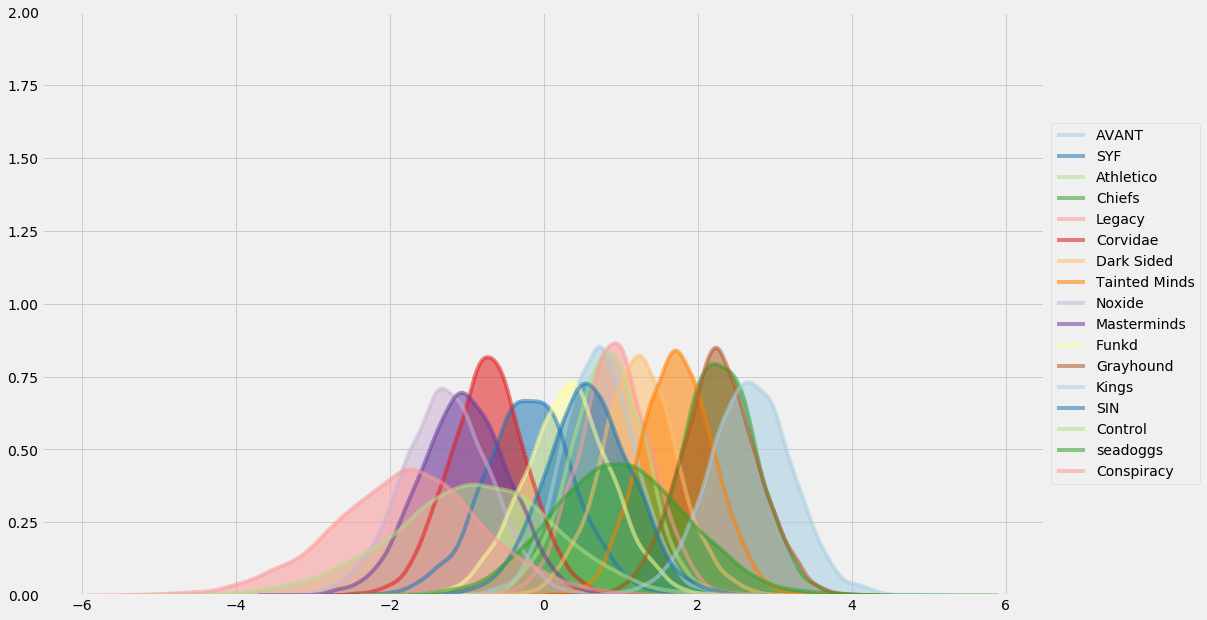

In [342]:
team_names = h_teams.loc[teams]
filt = team_names[team_names.Name.isin(FILTER_TEAMS[EVENT_SET])]
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,2.0)
[sns.kdeplot(trace['rating'][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
{v['Name']: trace['rating'][:,tmap[i]].std() for i,v in filt.iterrows()}

# Save Model

In [343]:
pm.backends.text.dump('saved_model/'+EVENT_SET+'/trace', trace)
np.save('saved_model/'+EVENT_SET+'/teams.npy', teams)
np.save('saved_model/'+EVENT_SET+'/maps.npy', maps)
np.save('saved_model/'+EVENT_SET+'/filter_teams.npy', FILTER_TEAMS[EVENT_SET])

## Diagnostics

In [ ]:
with rating_model:
    approx = pm.fit(15000)
    ap_trace = approx.sample(5000)

In [ ]:
print('Gelman Rubin: %s' % pm.diagnostics.gelman_rubin(trace))
print('Effective N: %s' % pm.diagnostics.effective_n(trace))
print('Accept Prob: %.4f' % trace.get_sampler_stats('mean_tree_accept').mean())
print('Percentage of Divergent %.5f' % (trace['diverging'].nonzero()[0].size/float(len(trace))))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024921883358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002492A1F7C18>]], dtype=object)

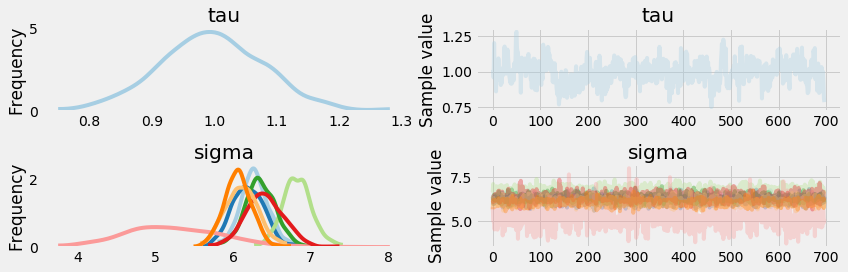

In [58]:
pm.traceplot(trace, varnames=['tau', 'sigma'])

In [315]:
rating_model.profile(pm.gradient(rating_model.logpt, rating_model.vars), n=100).summary()

Function profiling
  Message: C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:853
  Time in 100 calls to Function.__call__: 1.456671e+01s
  Time in Function.fn.__call__: 1.455773e+01s (99.938%)
  Time in thunks: 1.318017e+01s (90.481%)
  Total compile time: 2.747486e+01s
    Number of Apply nodes: 57
    Theano Optimizer time: 9.291786e+00s
       Theano validate time: 8.006334e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.801155e+01s
       Import time 1.096895e+00s
       Node make_thunk time 1.800746e+01s
           Node InplaceDimShuffle{x,x,0}(rating) time 2.330166e+00s
           Node Elemwise{Composite{(Switch(i0, (i1 * i2 * i3 * i4 * i5 * i6), i7) + (i8 * i9 * i10 * i6))}}(InplaceDimShuffle{0,x,x}.0, TensorConstant{(1, 1, 1) of 11.152}, InplaceDimShuffle{0,x,x}.0, InplaceDimShuffle{0,x,x}.0, InplaceDimShuffle{0,x,x}.0, Elemwise{sub,no_inplace}.0, TensorConstant{[[[ 0.  0... 0.  0.]]]}, TensorConstant{(1, 1, 1) 

In [49]:
rating_model.profile(rating_model.logpt, n=100).summary()

Function profiling
  Message: C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:853
  Time in 100 calls to Function.__call__: 5.413818e-02s
  Time in Function.fn.__call__: 5.062270e-02s (93.506%)
  Time in thunks: 4.911828e-02s (90.728%)
  Total compile time: 6.317694e+00s
    Number of Apply nodes: 29
    Theano Optimizer time: 2.917802e-01s
       Theano validate time: 2.459049e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 5.855421e+00s
       Import time 2.826359e-01s
       Node make_thunk time 5.853460e+00s
           Node Elemwise{Composite{Switch(Identity(GT(i0, i1)), (i2 * ((-(Composite{inv(sqr(i0))}(i0) * sqr((i3 - (i4 * ultra_fast_scalar_sigmoid((i5 * i6))))))) + log((i7 * Composite{inv(sqr(i0))}(i0))))), i8)}}[(0, 0)](AdvancedSubtensor1.0, TensorConstant{(1,) of 0}, TensorConstant{(1,) of 0.5}, TensorConstant{[ 30.  23... 14.  14.]}, TensorConstant{(1,) of 32.0}, TensorConstant{(1,) of 0.3485}, Elemwise{Sub}[(0,

## Moar Plots

In [ ]:
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,2.0)
[sns.kdeplot(trace['sigma'][:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=m) for i,m in enumerate(maps)]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
f, axes = plt.subplots(n_maps,1,figsize=(12,34), sharex=True)
for m, ax in enumerate(axes):
    ax.set_title(dict(enumerate(maps))[m])
    ax.set_ylim(0,2.0)
    [sns.kdeplot(trace['rating | map'][:,m,tmap[i]], shade=True, alpha=0.55, legend=False ,
                 ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
filt

In [ ]:
i = np.where(teams==7880)
j = np.where(teams==7924)

diff = (trace['rating'][:,j] - trace['rating'][:,i]).flatten()
kappa = 32./(1+np.exp(-1.*trace['alpha']*diff))-16.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
sns.kdeplot(kappa, ax=ax2)
sns.kdeplot(diff, ax=ax1)

## Non-MCMC Model

In [ ]:
def vec2dict(s, n_teams):
    return {
        'mu': np.array(s[:n_teams]),
        'sigma': np.array(s[n_teams:n_teams*2]),
        'beta': s[-1],
    }

def dict2vec(s):
    return s['mu'] + s['sigma'] + [s['beta']]

In [ ]:
skills_0 = dict2vec({
    'mu': [1000]*n_teams,
    'sigma': [300]*n_teams,
    'beta': 50
})

In [ ]:
from scipy.optimize import minimize


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1-y)*np.log(1.-p)))

def obj(skills):
    s = vec2dict(skills, n_teams)
    mean_diff = s['mu'][obs['Team 1 ID'].map(tmap).values] - s['mu'][obs['Team 2 ID'].map(tmap).values]
    var_diff = s['sigma'][obs['Team 1 ID'].map(tmap).values]**2 + s['sigma'][obs['Team 2 ID'].map(tmap).values]**2 + skills[-1]**2
    p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
    return loglike((obs['Team 1 ID'] == obs['winner']).values, p)


In [ ]:
obj(skills_0)

In [ ]:
opt_skill = g.x
print(opt_skill)
plots = norm.rvs(opt_skill[:5], opt_skill[5:-1], size=(2000,5))

f, ax = plt.subplots(figsize=(12,8))
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]